## dataset
[] short sentenses are merge into long
[] doc packed per paragraph
[] 3 paragraphs build single sequence
[] sequence from sentences where seq_len is length of document - features include neighbors -2,-1,+1,+2 of entire document

In [14]:
import pandas as pd
import os,sys, imp
sys.path.append('./src/')
import doc_utils_clean as doc_utils
import feature_utils
import defines
import numpy as np
from sklearn_crfsuite import scorers, CRF
from sklearn_crfsuite import metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import LeaveOneGroupOut,LeavePGroupsOut,GroupKFold

from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import random
import model_utils
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [3]:
dir_name="recalc_tfidf"

In [4]:
db_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name)

In [5]:
imp.reload(doc_utils)
doc_db =  pd.read_csv("./dataframes/doc_db.csv")
doc_db.sort_values(by='doc_idx_from_name',inplace=True)
doc_db

path              file_name  \
0   /path1   /path2   /path3   /path4   /path..                                                ...                    ...   
75  /path76  /path77  /path78  /path79  /path
    doc_idx_from_name  par_count  sent_count  nar_sent_count  
0                   1 205.000000  580.000000      256.000000  
1                   2 157.000000  632.000000       70.000000  
2                   3 118.000000  559.000000      102.000000  
3                   4 132.000000  460.000000      172.000000  
4                   5  65.000000  510.000000      270.000000  
..                ...        ...         ...             ...  
75                 76 132.000000  464.000000      164.000000  
76                 77 176.000000  406.000000       64.000000  
77                 78 122.000000  178.000000       44.000000  
78                 79 173.000000  252.000000       70.000000  
79                 80 225.000000  491.000000      102.000000  

[80 rows x 6 columns]

In [303]:
imp.reload(feature_utils)
# docs_map = feature_utils.pack_all_doc_sentences_to_map(dir_name,per_par=True,limit=0,doc_as_sequence=1,sent_lemma_db_list=[])
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"docs_map.json")
with open(json_path, 'r') as fp:
    docs_map = json.load(fp)


### Flow:
- Save doc names/statistic
- Parse doc
- Calculate POS
- Calculate vectors
- Calc tfidf
- Calculate similarity
- Save docs' features
- Proceed paragraphs (split long)
- Pask features to dictionary per doc/ per paragraph


In [305]:
docs_map['23']['X'][12]

[{'is_question': 0.0,
  'par_idx_in_doc': 12.0,
  'sent_len': 88.0,
  'is_client': 0,
  'sent_idx_in_par': 0,
  'sent_pos_in_par': 0.5,
  'sent_pos_in_doc': 0.2448979591836734,
  'TOKEN': 21,
  'POSTAG_BN': 0.0952380952380952,
  'POSTAG_DTT': 0.0476190476190476,
  'POSTAG_IN': 0.1904761904761904,
  'POSTAG_JJ': 0.0476190476190476,
  'POSTAG_MD': 0.0476190476190476,
  'POSTAG_PREPOSITION': 0.0476190476190476,
  'POSTAG_PRP': 0.3333333333333333,
  'POSTAG_QW': 0.0476190476190476,
  'POSTAG_RB': 0.1428571428571428,
  'POSTAG_REL': 0.0952380952380952,
  'POSTAG_S_PRN': 0.0952380952380952,
  'POSTAG_VB': 0.0476190476190476,
  'f_gen_F': 0.1904761904761904,
  'f_gen_M': 0.4285714285714285,
  'f_num_S': 0.6190476190476191,
  'f_per_1': 0.1904761904761904,
  'f_per_2': 0.0476190476190476,
  'f_per_3': 0.1904761904761904,
  'f_per_A': 0.1428571428571428,
  'sent_idx': 71,
  '-1:is_question': 0.0,
  '-1:par_idx_in_doc': 11.0,
  '-1:sent_len': 48.0,
  '-1:is_client': 1,
  '-1:sent_idx_in_par': 3,

In [306]:
imp.reload(feature_utils)
imp.reload(model_utils)
seq_len=3
step=3
per_par=True
feature_utils.reshape_docs_map_to_seq(docs_map,per_par,seq_len,step)

[68] 439 -> 147 [57] 271 -> 91 [42] 136 -> 46 [63] 338 -> 113 [76] 132 -> 44 [49] 206 -> 69 [21] 108 -> 36 [34] 49 -> 17 [15] 121 -> 41 [39] 111 -> 37 [13] 90 -> 30 [6] 420 -> 140 [27] 67 -> 23 [32] 73 -> 25 [18] 62 -> 21 [65] 335 -> 112 [70] 183 -> 61 [51] 208 -> 70 [44] 199 -> 67 [48] 223 -> 75 [62] 248 -> 83 [77] 176 -> 59 [56] 268 -> 90 [43] 99 -> 33 [69] 517 -> 173 [14] 129 -> 43 [1] 203 -> 68 [20] 90 -> 30 [35] 63 -> 21 [19] 265 -> 89 [26] 114 -> 38 [33] 91 -> 31 [12] 150 -> 50 [7] 248 -> 83 [38] 90 -> 30 [50] 184 -> 62 [45] 204 -> 68 [64] 347 -> 116 [71] 156 -> 52 [2] 156 -> 52 [17] 322 -> 108 [28] 167 -> 56 [80] 223 -> 75 [9] 276 -> 92 [36] 87 -> 29 [23] 74 -> 25 [74] 95 -> 32 [61] 433 -> 145 [40] 148 -> 50 [55] 249 -> 83 [46] 200 -> 67 [53] 149 -> 50 [79] 172 -> 58 [58] 384 -> 128 [72] 420 -> 140 [67] 407 -> 136 [30] 82 -> 28 [25] 122 -> 41 [4] 132 -> 44 [11] 121 -> 41 [37] 99 -> 33 [22] 89 -> 30 [8] 82 -> 28 [29] 105 -> 35 [3] 113 -> 38 [16] 102 -> 34 [41] 137 -> 46 [54] 243 

In [27]:
docs_map['1'].keys()

NameError: name 'docs_map' is not defined

### Run single example - sequence = 3x paragraph [1:3][4:6]...

In [17]:
import scipy
import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [316]:
imp.reload(model_utils)
test_percent = 0.2
seed=42
num_splits=10
X_train,y_train,X_test,y_test,test_idx,groups_train,groups_test =  model_utils.split_test_train_docs(docs_map,test_percent,seq_len,step,seed)

In [317]:
%%time
# define fixed parameters and parameters to search
crf = CRF(
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    'algorithm': ['lbfgs' ,'l2sgd','ap','pa','arow'],
    'min_freq': np.arange(1,11,2) 
}

labels = ['not_nar','is_nar']
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)


rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
102 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimator.py", line 310, in fit
    trainer = self._get_trainer()
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimat

CPU times: user 1min 20s, sys: 22.6 s, total: 1min 43s
Wall time: 1min 56s


RandomizedSearchCV(cv=3,
                   estimator=CRF(all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['lbfgs', 'l2sgd', 'ap',
                                                      'pa', 'arow'],
                                        'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2ac22cc985e0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2ac2fdb161f0>,
                                        'min_freq': array([1, 3, 5, 7, 9])},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=1)

In [318]:
rs

RandomizedSearchCV(cv=3,
                   estimator=CRF(all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['lbfgs', 'l2sgd', 'ap',
                                                      'pa', 'arow'],
                                        'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2ac22cc985e0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2ac2fdb161f0>,
                                        'min_freq': array([1, 3, 5, 7, 9])},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=1)

In [319]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'algorithm': 'lbfgs', 'c1': 0.39339816234402913, 'c2': 0.07148208542452641, 'min_freq': 3}
best CV score: 0.7893587627247691
model size: 0.68M


In [138]:
def convert_to_python_types(_dic):
    dic = {}
    for key,val in _dic.items():
        if not isinstance(val,str):
            dic[key]=val.item()
        else:
            dic[key]=val
    return dic

In [320]:
import json
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"best_params_lemma.word_default_cv_2.json")

best_params_pyth = convert_to_python_types(rs.best_params_)
with open(json_path, 'w') as fp:
    json.dump(best_params_pyth, fp)


In [321]:
rs.cv_results_

{'mean_fit_time': array([3.21658452e-03, 3.42917442e-03, 3.50149473e-03, 3.03093592e-03,
        3.36567561e-03, 1.06902792e+01, 1.23037952e+01, 1.09194230e+01,
        3.28342120e-03, 3.23836009e-03, 3.40032578e-03, 3.28191121e-03,
        1.14376930e+01, 1.23133935e+01, 3.91554832e-03, 3.21690241e-03,
        1.17534675e+01, 1.79036458e-03, 1.72845523e-03, 1.24414719e+01,
        1.90560023e-03, 1.64087613e-03, 1.73068047e-03, 1.62847837e-03,
        1.53668722e-03, 1.04557276e+01, 1.03963186e+01, 2.14274724e-03,
        1.08499765e+01, 1.71875954e-03, 2.05977758e-03, 1.94692612e-03,
        1.95709864e-03, 1.82533264e-03, 2.09808350e-03, 1.06079423e+01,
        1.93754832e-03, 1.20939215e+01, 1.98626518e-03, 1.15860710e+01,
        1.83057785e-03, 2.00835864e-03, 1.13265484e+01, 1.86936061e-03,
        1.09817129e+01, 1.12790557e+01, 2.20839183e-03, 2.00859706e-03,
        1.96305911e-03, 2.02767054e-03]),
 'std_fit_time': array([6.22392461e-04, 1.44729831e-04, 2.46886273e-04, 9.949

Dark blue => nan, dark red => nan


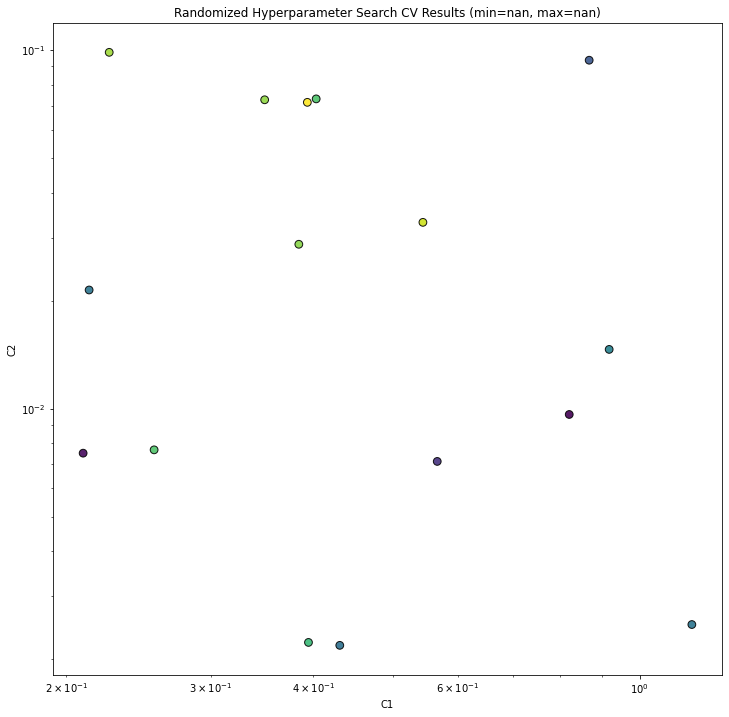

In [322]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [323]:
best_crf = rs.best_estimator_
y_pred  =  best_crf.predict(X_test)

              precision    recall  f1-score   support

      is_nar       0.62      0.62      0.62      1619
     not_nar       0.89      0.89      0.89      5524

    accuracy                           0.83      7143
   macro avg       0.76      0.76      0.76      7143
weighted avg       0.83      0.83      0.83      7143



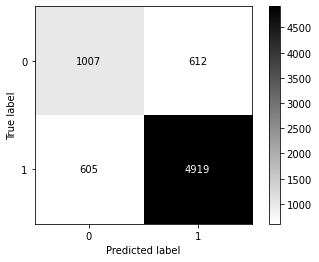

In [324]:
feature_utils.get_prediction_report(flatten(y_test),flatten(y_pred),crf.classes_)

## Use custom CV - keep document borders

In [19]:
imp.reload(model_utils)
imp.reload(defines)
my_cv = model_utils.ByDocFold()

In [326]:
%%time
# define fixed parameters and parameters to search
crf_cv = CRF(
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    'algorithm': ['lbfgs' ,'l2sgd','ap','pa','arow'],
    'min_freq': np.arange(1,11,2),
    'linesearch': ['MoreThuente','Backtracking','StrongBacktracking']
}

labels = ['not_nar','is_nar']
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs_cv = RandomizedSearchCV(crf_cv, params_space,
                        cv=my_cv,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)

rs_cv.fit(X=X_train, y=y_train,groups=groups_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
129 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimator.py", line 310, in fit
    trainer = self._get_trainer()
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimat

CPU times: user 1min 19s, sys: 23.2 s, total: 1min 42s
Wall time: 1min 50s


RandomizedSearchCV(cv=<model_utils.ByDocFold object at 0x2ac236bcaac0>,
                   estimator=CRF(all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['lbfgs', 'l2sgd', 'ap',
                                                      'pa', 'arow'],
                                        'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2ac2e31136a0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2ac2e3113970>,
                                        'linesearch': ['MoreThuente',
                                                       'Backtracking',
                                                       'StrongBacktracking'],
                                        'min_freq': array([1, 3, 5, 7, 9])},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=1)

In [167]:
len(y_train)

4151

In [327]:
# crf = rs.best_estimator_
print('best params:', rs_cv.best_params_)
print('best CV score:', rs_cv.best_score_)
print('model size: {:0.2f}M'.format(rs_cv.best_estimator_.size_ / 1000000))

best params: {'algorithm': 'lbfgs', 'c1': 0.5052489623208797, 'c2': 0.03723629092212718, 'linesearch': 'MoreThuente', 'min_freq': 9}
best CV score: 0.8073256472482112
model size: 0.35M


In [328]:
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"best_params_lemma.word_docFoldCv_2.json")

best_params_pyth = convert_to_python_types(rs_cv.best_params_)
with open(json_path, 'w') as fp:
    json.dump(best_params_pyth, fp)

In [329]:
best_crf_cv = rs_cv.best_estimator_
y_pred_cv  =  best_crf_cv.predict(X_test)

              precision    recall  f1-score   support

     not_nar       0.89      0.91      0.90      5524
      is_nar       0.67      0.61      0.63      1619

    accuracy                           0.84      7143
   macro avg       0.78      0.76      0.77      7143
weighted avg       0.84      0.84      0.84      7143



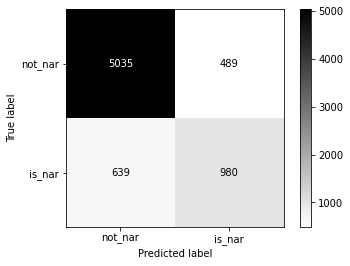

In [330]:
feature_utils.get_prediction_report(flatten(y_test),flatten(y_pred_cv),best_crf_cv.classes_)

### Look at the features

In [331]:
imp.reload(model_utils)
all_features_cv = model_utils.get_features_df(dir_name,Counter(best_crf_cv.state_features_).most_common())

In [332]:
all_features_cv.describe()

,weight
count,5839.000000
mean,0.038285
std,0.284369
min,-3.293131
25%,-0.000442
50%,0.000004
75%,0.002037
max,3.266547


In [349]:
all_features_cv[all_features_cv['label']=='is_nar'].head(30)

,weight,label,attr,string
3,2.567937,is_nar,tfidf_lemma_2811,הקשיב
5,2.551014,is_nar,tfidf_char_wb_2770,התק
14,2.103031,is_nar,tfidf_lemma_7802,ערך
23,1.911314,is_nar,tfidf_lemma_9561,שן
26,1.882205,is_nar,tfidf_lemma_4499,יישב
30,1.838516,is_nar,tfidf_lemma_3212,התעצבן
33,1.806465,is_nar,tfidf_char_wb_19229,יבו
39,1.721279,is_nar,tfidf_word_22194,רצית
46,1.582789,is_nar,tfidf_char_wb_720,בג
48,1.566860,is_nar,tfidf_lemma_9484,שלח


In [333]:
all_features_cv[all_features_cv['attr'].str.contains('idx')]

,weight,label,attr,string
791,0.037139,is_nar,sent_idx_in_par,
951,0.018467,not_nar,+2:sent_idx_in_par,
961,0.017115,not_nar,-1:sent_idx_in_par,
1146,0.007084,is_nar,+1:sent_idx_in_par,
1250,0.004730,not_nar,-2:sent_idx_in_par,
1830,0.000574,not_nar,par_idx_in_doc,
2002,0.000311,is_nar,+1:par_idx_in_doc,
2021,0.000295,not_nar,-2:par_idx_in_doc,
2038,0.000282,is_nar,-1:par_idx_in_doc,
2094,0.000239,not_nar,sent_idx,


In [334]:
all_features_cv[all_features_cv['attr'].str.contains('tense')]

,weight,label,attr,string
140,0.776286,not_nar,+2:f_tense_IMPERATIVE,
366,0.237515,not_nar,f_tense_IMPERATIVE,
412,0.195191,is_nar,f_tense_PAST,
474,0.145224,is_nar,-1:f_tense_PAST,
484,0.138943,not_nar,+2:f_tense_FUTURE,
496,0.135656,not_nar,+1:f_tense_FUTURE,
512,0.128440,not_nar,f_tense_FUTURE,
523,0.120259,is_nar,-2:f_tense_PAST,
570,0.100474,not_nar,-1:f_tense_FUTURE,
604,0.086635,not_nar,-2:f_tense_FUTURE,


In [335]:
all_features_cv[~all_features_cv['attr'].str.contains('tf')]

,weight,label,attr,string
110,0.989893,not_nar,+1:POSTAG_P,
140,0.776286,not_nar,+2:f_tense_IMPERATIVE,
311,0.325156,is_nar,-1:f_suf_per_1.0,
330,0.300559,not_nar,-1:f_suf_gen_F,
366,0.237515,not_nar,f_tense_IMPERATIVE,
...,...,...,...,...
5647,-0.195191,not_nar,f_tense_PAST,
5684,-0.237515,is_nar,f_tense_IMPERATIVE,
5705,-0.300559,is_nar,-1:f_suf_gen_F,
5714,-0.325156,not_nar,-1:f_suf_per_1.0,


### Save all features db

In [366]:
f_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"crf_features.csv")
all_features_cv.to_csv(f_path,index=False)

## Feature selection based on weight

<AxesSubplot:ylabel='Frequency'>

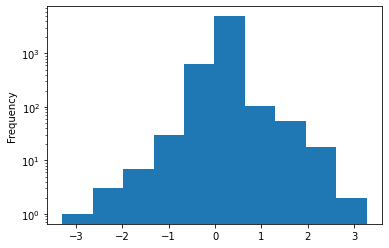

In [337]:
all_features_cv['weight'].plot(kind='hist',logy=True)

In [338]:
q = all_features_cv['weight'].quantile(q=[0.1, 0.9])
q

0.100000   -0.022234
0.900000    0.096775
Name: weight, dtype: float64

In [339]:
q.iloc[0],q.iloc[1]

(-0.022233799999999998, 0.096775)

In [342]:
heavy_featucres = all_features_cv.query("weight <= @q.iloc[0] or weight >= @q.iloc[1]")

In [343]:
heavy_featucres

,weight,label,attr,string
0,3.266547,not_nar,tfidf_word_22335,שאמרת
1,2.777927,not_nar,tfidf_lemma_1223,בחיר
2,2.600738,not_nar,tfidf_lemma_2823,הרגיע
3,2.567937,is_nar,tfidf_lemma_2811,הקשיב
4,2.557813,not_nar,tfidf_word_15077,לסיים
...,...,...,...,...
5834,-1.936926,not_nar,tfidf_lemma_5645,מוקדם
5835,-2.123519,not_nar,tfidf_word_15972,מבחינה
5836,-2.182424,not_nar,tfidf_char_wb_29417,קופ
5837,-2.434070,not_nar,tfidf_char_wb_6247,נה


In [344]:
light_features = all_features_cv.query("weight > @q.iloc[0] and weight < @q.iloc[1]")
light_features

,weight,label,attr,string
584,0.096774,not_nar,tfidf_word_14745,ללמוד
585,0.096565,is_nar,tfidf_char_wb_11896,גיל
586,0.096174,not_nar,tfidf_char_wb_24599,מלא
587,0.093029,is_nar,tfidf_lemma_4023,חץ
588,0.092053,is_nar,tfidf_char_wb_4636,לו
...,...,...,...,...
5250,-0.021812,not_nar,tfidf_char_wb_29418,קופה
5251,-0.021855,is_nar,tfidf_word_11147,זה
5252,-0.021977,not_nar,tfidf_char_wb_9502,אמא
5253,-0.022201,is_nar,+1:f_gen_M,


In [284]:
heave_features_list = heavy_features['attr'].tolist()
len(heave_features_list)

614

In [354]:
heavy_docs_map = docs_map.copy()

In [351]:
len(heavy_docs_map['68']['X'][13][0])

134

In [355]:
for doc in list(docs_map.keys()):
    print("doc {}".format(doc),end=' ')
    for i,par in enumerate(docs_map[doc]['X']):
        for j,sent in enumerate(par):
            heavy_sent = {}
            for key,item in sent.items():
                if key in heave_features_list:
                    heavy_sent[key]=item
            if len(sent.keys())!=len(heavy_sent.keys()):
#                 print("{}->{} |".format(len(sent.keys()),len(heavy_sent.keys())),end=' ')
                heavy_docs_map[doc]['X'][i][j]=heavy_sent

doc 68 doc 57 doc 42 doc 63 doc 76 doc 49 doc 21 doc 34 doc 15 doc 39 doc 13 doc 6 doc 27 doc 32 doc 18 doc 65 doc 70 doc 51 doc 44 doc 48 doc 62 doc 77 doc 56 doc 43 doc 69 doc 14 doc 1 doc 20 doc 35 doc 19 doc 26 doc 33 doc 12 doc 7 doc 38 doc 50 doc 45 doc 64 doc 71 doc 2 doc 17 doc 28 doc 80 doc 9 doc 36 doc 23 doc 74 doc 61 doc 40 doc 55 doc 46 doc 53 doc 79 doc 58 doc 72 doc 67 doc 30 doc 25 doc 4 doc 11 doc 37 doc 22 doc 8 doc 29 doc 3 doc 16 doc 41 doc 54 doc 75 doc 60 doc 73 doc 66 doc 59 doc 78 doc 47 doc 52 doc 5 doc 10 doc 31 doc 24 

## Run GridSearch with only heavy features

In [361]:
imp.reload(feature_utils)
imp.reload(model_utils)
seq_len=3
step=3
per_par=True
feature_utils.reshape_docs_map_to_seq(heavy_docs_map,per_par,seq_len,step)

[68] 439 -> 147 [57] 271 -> 91 [42] 136 -> 46 [63] 338 -> 113 [76] 132 -> 44 [49] 206 -> 69 [21] 108 -> 36 [34] 49 -> 17 [15] 121 -> 41 [39] 111 -> 37 [13] 90 -> 30 [6] 420 -> 140 [27] 67 -> 23 [32] 73 -> 25 [18] 62 -> 21 [65] 335 -> 112 [70] 183 -> 61 [51] 208 -> 70 [44] 199 -> 67 [48] 223 -> 75 [62] 248 -> 83 [77] 176 -> 59 [56] 268 -> 90 [43] 99 -> 33 [69] 517 -> 173 [14] 129 -> 43 [1] 203 -> 68 [20] 90 -> 30 [35] 63 -> 21 [19] 265 -> 89 [26] 114 -> 38 [33] 91 -> 31 [12] 150 -> 50 [7] 248 -> 83 [38] 90 -> 30 [50] 184 -> 62 [45] 204 -> 68 [64] 347 -> 116 [71] 156 -> 52 [2] 156 -> 52 [17] 322 -> 108 [28] 167 -> 56 [80] 223 -> 75 [9] 276 -> 92 [36] 87 -> 29 [23] 74 -> 25 [74] 95 -> 32 [61] 433 -> 145 [40] 148 -> 50 [55] 249 -> 83 [46] 200 -> 67 [53] 149 -> 50 [79] 172 -> 58 [58] 384 -> 128 [72] 420 -> 140 [67] 407 -> 136 [30] 82 -> 28 [25] 122 -> 41 [4] 132 -> 44 [11] 121 -> 41 [37] 99 -> 33 [22] 89 -> 30 [8] 82 -> 28 [29] 105 -> 35 [3] 113 -> 38 [16] 102 -> 34 [41] 137 -> 46 [54] 243 

In [362]:
imp.reload(model_utils)
test_percent = 0.2
seed=42
num_splits=10
X_train,y_train,X_test,y_test,test_idx,groups_train,groups_test =  model_utils.split_test_train_docs(heavy_docs_map,test_percent,seq_len,step,seed)

In [363]:
%%time
# define fixed parameters and parameters to search
crf_heavy = CRF(
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    'algorithm': ['lbfgs' ,'l2sgd','ap','pa','arow'],
    'min_freq': np.arange(1,11,2),
    'linesearch': ['MoreThuente','Backtracking','StrongBacktracking']
}

labels = ['not_nar','is_nar']
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs_heavy = RandomizedSearchCV(crf_heavy, params_space,
                        cv=my_cv,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)

rs_heavy.fit(X=X_train, y=y_train,groups=groups_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
117 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimator.py", line 310, in fit
    trainer = self._get_trainer()
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimat

CPU times: user 16.9 s, sys: 16.1 s, total: 33.1 s
Wall time: 34.2 s


RandomizedSearchCV(cv=<model_utils.ByDocFold object at 0x2ac236bcaac0>,
                   estimator=CRF(all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['lbfgs', 'l2sgd', 'ap',
                                                      'pa', 'arow'],
                                        'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2ac3084c9790>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2ac3084e6550>,
                                        'linesearch': ['MoreThuente',
                                                       'Backtracking',
                                                       'StrongBacktracking'],
                                        'min_freq': array([1, 3, 5, 7, 9])},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=1)

In [364]:
# crf = rs.best_estimator_
print('best params:', rs_heavy.best_params_)
print('best CV score:', rs_heavy.best_score_)
print('model size: {:0.2f}M'.format(rs_heavy.best_estimator_.size_ / 1000000))

best params: {'algorithm': 'lbfgs', 'c1': 0.29533457543727304, 'c2': 0.06480265286799039, 'linesearch': 'StrongBacktracking', 'min_freq': 5}
best CV score: 0.7821916732280658
model size: 0.04M


### Conclustion: selecting only heavy features gives lower f1 CV score, so better take all the features

## Try to run with sequencec of 8 sentences

In [10]:
per_par = False
seq_len = 8
step = 8

In [7]:
docs_map_sent = feature_utils.pack_all_doc_sentences_to_map(dir_name,per_par,limit=0,doc_as_sequence=1,sent_lemma_db_list=[])

68 doc 898 sentences packed
0 57 doc 441 sentences packed
1 42 doc 199 sentences packed
2 63 doc 533 sentences packed
3 76 doc 464 sentences packed
4 49 doc 298 sentences packed
5 21 doc 598 sentences packed
6 34 doc 385 sentences packed
7 15 doc 648 sentences packed
8 39 doc 170 sentences packed
9 13 doc 677 sentences packed
10 6 doc 779 sentences packed
11 27 doc 241 sentences packed
12 32 doc 354 sentences packed
13 18 doc 142 sentences packed
14 65 doc 655 sentences packed
15 70 doc 251 sentences packed
16 51 doc 463 sentences packed
17 44 doc 473 sentences packed
18 48 doc 491 sentences packed
19 62 doc 395 sentences packed
20 77 doc 406 sentences packed
21 56 doc 503 sentences packed
22 43 doc 209 sentences packed
23 69 doc 968 sentences packed
24 14 doc 618 sentences packed
25 1 doc 580 sentences packed
26 20 doc 269 sentences packed
27 35 doc 468 sentences packed
28 19 doc 345 sentences packed
29 26 doc 456 sentences packed
30 33 doc 454 sentences packed
31 12 doc 699 sentences

In [11]:
feature_utils.reshape_docs_map_to_seq(docs_map_sent,False,seq_len,step)

doc sentences reshaped: from 898 to 113
doc sentences reshaped: from 441 to 56
doc sentences reshaped: from 199 to 25
doc sentences reshaped: from 533 to 67
doc sentences reshaped: from 464 to 58
doc sentences reshaped: from 298 to 38
doc sentences reshaped: from 598 to 75
doc sentences reshaped: from 385 to 49
doc sentences reshaped: from 648 to 81
doc sentences reshaped: from 170 to 22
doc sentences reshaped: from 677 to 85
doc sentences reshaped: from 779 to 98
doc sentences reshaped: from 241 to 31
doc sentences reshaped: from 354 to 45
doc sentences reshaped: from 142 to 18
doc sentences reshaped: from 655 to 82
doc sentences reshaped: from 251 to 32
doc sentences reshaped: from 463 to 58
doc sentences reshaped: from 473 to 60
doc sentences reshaped: from 491 to 62
doc sentences reshaped: from 395 to 50
doc sentences reshaped: from 406 to 51
doc sentences reshaped: from 503 to 63
doc sentences reshaped: from 209 to 27
doc sentences reshaped: from 968 to 121
doc sentences reshaped:

In [15]:
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"docs_map_sent.json")
with open(json_path, 'w') as fp:
    json.dump(docs_map_sent,fp)

In [21]:
imp.reload(model_utils)
test_percent = 0.2
seed=42
num_splits=10
X_train,y_train,X_test,y_test,test_idx,groups_train,groups_test =  model_utils.split_test_train_docs(docs_map_sent,test_percent,seq_len,step,seed)

In [22]:
%%time
# define fixed parameters and parameters to search
crf_8sent = CRF(
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    'algorithm': ['lbfgs' ,'l2sgd','ap','pa','arow'],
    'min_freq': np.arange(1,11,2),
    'linesearch': ['MoreThuente','Backtracking','StrongBacktracking']
}

labels = ['not_nar','is_nar']
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs_8sent = RandomizedSearchCV(crf_8sent, params_space,
                        cv=my_cv,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs_8sent.fit(X=X_train, y=y_train,groups=groups_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimator.py", line 310, in fit
    trainer = self._get_trainer()
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimat

CPU times: user 4min 25s, sys: 49.7 s, total: 5min 15s
Wall time: 5min 30s


RandomizedSearchCV(cv=<model_utils.ByDocFold object at 0x2ab6b9986ac0>,
                   estimator=CRF(all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['lbfgs', 'l2sgd', 'ap',
                                                      'pa', 'arow'],
                                        'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2ab7da55e730>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2ab7da4cbd00>,
                                        'linesearch': ['MoreThuente',
                                                       'Backtracking',
                                                       'StrongBacktracking'],
                                        'min_freq': array([1, 3, 5, 7, 9])},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=1)

In [23]:
print('best params:', rs_8sent.best_params_)
print('best CV score:', rs_8sent.best_score_)
print('model size: {:0.2f}M'.format(rs_8sent.best_estimator_.size_ / 1000000))

best params: {'algorithm': 'lbfgs', 'c1': 0.4221460751582265, 'c2': 0.09168983449868534, 'linesearch': 'StrongBacktracking', 'min_freq': 5}
best CV score: 0.7837411781410664
model size: 0.53M


In [25]:
docs_map_sent[58].keys()

dict_keys(['X', 'y', 'groups', 'X_8_8', 'y_8_8', 'groups_8_8'])

### Conclusion:
model on 8x sentences performance is poor comparing to on paragraphs